In [65]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import scipy.io as spio
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

## Read-in, visualise, convert, flatten and concatenate data

In [49]:
IP_data_mat=spio.loadmat("data/IP/Indian_pines_corrected.mat")
IP_gt_mat=spio.loadmat("data/IP/Indian_pines_gt.mat")
IP_image=IP_data_mat["indian_pines_corrected"]
IP_gt=IP_gt_mat['indian_pines_gt']

pavia_mat = spio.loadmat('data/PaviaU/PaviaU.mat')
pavia_gt_mat = spio.loadmat('data/PaviaU/PaviaU_gt.mat')
pavia_image = pavia_mat['paviaU']
pavia_gt = pavia_gt_mat['paviaU_gt']

salinas_mat = spio.loadmat('data/Salinas/salinas.mat')
salinas_gt_mat = spio.loadmat('data/Salinas/salinas_gt.mat')
salinas_image = salinas_mat['salinasA_corrected']
salinas_gt = salinas_gt_mat['salinasA_gt']

n, m, c = salinas_image.shape
salinas_image = np.reshape(salinas_image, (-1, c))
salinas_gt_flat = np.reshape(salinas_gt, -1)
salinas_image = salinas_image[salinas_gt_flat!=0]

# PCA
n_features = 5
pca = PCA(n_components=n_features)
pCs_salinas = pca.fit_transform(salinas_image)

In [50]:
class GMM:
    """
    Class implementing a Gaussian Mixture Model (GMM) with multivariate gaussians
        Requires: potential_features (data), n_coms (number of clusters), em_steps(number of iterations of EM) and
        n_features (the number of features to extract from potential_features)
        
        Contains: 
            GMM.run(), run EM with parameters specified at initialisation, will create appropriate plots
    """
    def __init__(self, potential_features, n_coms=2, em_steps=10, n_features=2):
        # Select desired features
        self.X = potential_features[:, :n_features]
        # Number of steps em will run for
        self.em_steps = em_steps
        # Number of components/clusters
        self.n_coms = n_coms
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        self.n_features=n_features
    def run(self):
        # Regulariser for the covariance matrix
        self.reg_cov = 1e-4*np.identity(len(self.X[0]))
        
        #x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        #self.XY = np.array([x.flatten(),y.flatten()]).T
        
        # Initialise mean value size (Number of components, number of features) and make float
        chosen = np.random.choice(len(self.X), self.n_coms, replace = False)
        self.mu = self.X[chosen]*1.0
        
        # Initialise zero matrices of size (number of components, number of features, number of features)
        shape = self.n_coms, len(self.X[0]), len(self.X[0])
        self.cov = np.full(shape, np.cov(self.X, rowvar = False))
        #self.cov = np.sqrt(self.cov) THIS WAS BREAKING THE COIN PIXELS
        self.cov += self.reg_cov
        
        initial_mu = self.mu.copy()
        initial_cov = self.cov.copy()
        
        # Initialise uniform pi values
        self.pi = np.full(self.n_coms, 1/self.n_coms)
        
        log_likelihoods = []
        
        # EM Loop
        i=0
        while True:
            # E Step
            #print("EM step %d/%d."%(i+1, self.em_steps), end='\r')
            
            # Compute responsibilities
            r_ic = np.zeros((len(self.X), self.n_coms))
            for c in range(self.n_coms):
                prior = self.pi[c]
                #print(self.mu[c], self.cov[c])
                likelihood = multivariate_normal(self.mu[c], self.cov[c]).pdf(self.X)
                r_ic[:, c] = prior * likelihood
            r_ic = r_ic/(r_ic.sum(axis = 1, keepdims = 1)+1e-9)
        
            # M Step
            
            self.pi = []
            self.mu = []
            self.cov = []
            
            for c in range(self.n_coms):
                # Update mean of each component
                m_c = np.sum(r_ic[:, c], axis=0)
                mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X), 1), axis=0)
                self.mu.append(mu_c)
                
                # Update covariance matrix of each component
                cov_c = (1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c))
                cov_c += self.reg_cov
                self.cov.append(cov_c)
                
                # Update pi values of each component
                self.pi.append(m_c/np.sum(r_ic))
            
            self.mu = np.array(self.mu)
            self.cov = np.array(self.cov)
            # Save log likelihood of each iteration
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(self.X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))
            i+=1
            print(np.round(log_likelihoods[i-1], 2), i, end='\r')
            if i>1:
                if np.abs(log_likelihoods[i-2]-log_likelihoods[i-1])<1e-4:
                    break

        print('Training complete')
        plt.plot(range(0, i, 1),log_likelihoods)
        plt.xlabel('Iterative steps')
        plt.ylabel('Log-likelihood')
        plt.savefig('log_likelihood_graph.png')
        plt.show()

Training complete


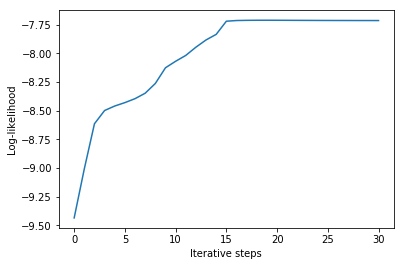

In [60]:
gmm_salinas = GMM(potential_features=pCs_salinas, n_coms=6, em_steps=50, n_features=2)
gmm_salinas.run()

In [61]:
def predict(Y, gmm):
    Y = Y[:, :gmm.n_features]
    labels = np.zeros((Y.shape[0], gmm.n_coms))
    for c in range(gmm.n_coms):
        labels [:,c] = gmm.pi[c] * multivariate_normal(gmm.mu[c,:], gmm.cov[c]).pdf(Y)
    labels  = labels.argmax(1)
    return labels
    

def compute_confusion_matrix(true, pred):
    K = len(np.unique(true))
    print(np.unique(true))
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

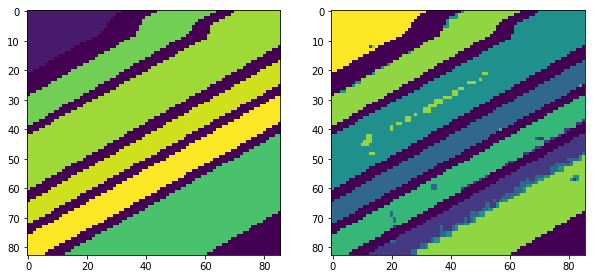

In [62]:
labels = predict(pCs_salinas, gmm_salinas)

count, loc, size = 0, 0, salinas_gt_flat.shape[0]
final = np.zeros(size)
while count<labels.shape[0]:
    if (salinas_gt_flat[loc]!=0):
        final[loc]=labels[count]+1
        count+=1
    loc+=1

final = np.reshape(final, (n, m))

f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(salinas_gt)
ax[1].imshow(final)
plt.show()

In [66]:
def randIndex(gt_labels, pred_labels):
    return adjusted_mutual_info_score(np.reshape(gt_labels, -1), np.reshape(pred_labels, -1), average_method='warn')

print(randIndex(salinas_gt, final))

/home/joshua/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8530955317687071
